**Table of contents**<a id='toc0_'></a>    
- 1. [Problem 1: Optimal taxation with government consumption](#toc1_)    
- 2. [Problem 2: Labor adjustment costs](#toc2_)    
- 3. [Problem 3: Global optimizer with refined multi-start](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [ ]:
# write your code here

## 1. <a id='toc1_'></a>[Problem 1: Optimal taxation with government consumption](#toc0_)


Consider a worker choosing hours of labor, $L\in[0,24]$, to maximize utility: 

$$
\begin{align*}
V(w,\tau,G)&=\max_{L\in[0,24]}\ln\left(C^{\alpha}G^{1-\alpha}\right)-\nu\frac{L^{2}}{2}\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}
$$

where 

* $C$ is *private* consumption with weight $\alpha\in(0,1)$.
* $\kappa > 0$ is the *free private* consumption component.
* $C = (1-\tau)wL$ is the *costly private* consumption component.
* $w > 0 $ is the real wage.
* $\tau \in (0,1)$ is the labor-income tax rate.
* $G > 0 $ is *government* consumption with weight $1-\alpha$.
* $\nu > 0$ is the disutility of labor scaling factor


The baseline parameters are:

$$
\begin{align*}
\alpha &= 0.5\\
\kappa &= 1.0\\
\nu &= \frac{1}{2\cdot16^2} \\
w &= 1.0 \\ 
\tau &= 0.30 \\
\end{align*}
$$

**Question 1:** Verify that the optimal labor supply choice is $L^{\star}(\tilde{w}) =\frac{-\kappa+\sqrt{\kappa^{2}+4\frac{\alpha}{\nu}\tilde{w}^2}}{2\tilde{w}}$, where $\tilde{w} = (1-\tau)w$, for $G\in\left\{1.0 , 2.0\right\}$.

In [ ]:
# write your code here

**Question 2:** Illustrate how $L^{\star}(\tilde{w})$ depends on $w$.

In [ ]:
# write your code here


We now consider a government, who chooses $\tau$ and spend all of the taxes on government consumption so:

$$
G = \tau w L^{\star}((1-\tau)w)
$$

**Question 3:** Plot the implied $L$, $G$ and worker utility for a grid of $\tau$-values.


In [ ]:
# write your code here

**Question 4:** Find the socially optimal tax rate $\tau^{\star}\in(0,1)$ maximizing worker utility. Illustrate your result.

In [ ]:
# write your code here

A more general preference formulation for the worker is:

$$
\begin{align*}
\mathcal{V}(w,\tau,G)&=\max_{L\in[0,24]}\frac{\left[ \left( \alpha C^{\frac{\sigma-1}{\sigma}}+(1-\alpha) G^{\frac{\sigma-1}{\sigma}} \right)^{\frac{\sigma}{1-\sigma} }\right]^{1-\rho}-1}{1-\rho}- \nu\frac{L^{1+\varepsilon}}{1+\varepsilon},\,\,\,\varepsilon,\rho,\sigma>0,\,\,\,\rho,\sigma\neq1\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}    
$$

Optimal labor supply is now $L^{\star}(\tilde{w},G)$.

Questions 5 and 6 must be answered with the general formulation, and for 2 different set of parameters:

- Set 1:  $\sigma = 1.001$, $\rho = 1.001$ and $\varepsilon = 1.0$.
- Set 2:  $\sigma = 1.5$, $\rho = 1.5$ and $\varepsilon = 1.0 $.

**Question 5:** Find the $G$ that solves $G = \tau w L^{\star}((1-\tau)w,G)$ using the $\tau$ found in question 4.

*Hint: First write code that solves the worker problem for given values of $G$ and $\tau$. Then find the correct G based on this.*

In [ ]:
# write your code here

**Question 6:** Find the socially optimal tax rate, $\tau^{\star}$, maximizing worker utility, while keeping $G = \tau w L^{\star}((1-\tau)w,G)$.

In [ ]:
# write your code here  

## 2. <a id='toc2_'></a>[Problem 2: Labor adjustment costs](#toc0_)

In [33]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# Local modules
import q2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


TypeError: unsupported operand type(s) for ^: 'float' and 'float'

You own a hair salon. You employ hairdressers, $\ell_t$, to produce haircuts, $y_t = \ell_t$.

The wage for each haridresser is $w$.

The demand for haircuts implies that the price of haircuts you can charge is $p_t = \kappa_t y_t^{-\eta}$, where $\kappa_t$ is a demand-shock and $\eta \in (0,1)$ measures the elasticity of demand.

Profits are:

$$
\Pi_t = p_t y_t - w \ell_t = \kappa_t \ell_t^{1-\eta} - w \ell_t
$$

Baseline parameters are:
- $\eta = 0.5$
- $w = 1.0$

**Question 1:** Verify numerically that $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ maximises profits, for $\kappa\in\left\{1.0 , 2.0\right\}$.

In [30]:
par = q2.par

kappas = [1.0, 2.0]

for kappa in kappas:
    l_optimal = optimal_l(kappa)
    profit_optimal = profit(kappa, l_optimal)

    l_values = np.linspace(0.5 * l_optimal, 2 * l_optimal, 100)
    profits = [profit(kappa, l) for l in l_values]

    print(f"For kappa = {kappa}:")
    print(f"Optimal l: {l_optimal}")
    print(f"Profit at optimal l: {profit_optimal}")
    print(f"Max profit computed: {max(profits)}")
    print()


NameError: name 'q2' is not defined

We now consider a *dynamic* version of the model.

* The demand-shock is a so-called AR(1) in logs, 

$$
\log \kappa_{t} = \rho \log \kappa_{t-1} + \epsilon_{t},\,\,\, \epsilon_{t+1} \sim \mathcal{N}(-0.5\sigma_{\epsilon}^2,\sigma_{\epsilon})
$$

* Any hiring or firing implies a fixed adjustment cost, $\iota > 0 $.
* Future profits are discounted with a monthly factor of $R \in (0,1)$.

The initial demand shock is $\kappa_{-1} = 1$ and the planning horizon is 10 years, i.e. 120 months so $t \in \{0,1,2,\dots,119\}$. Initially you don't have any employees, $\ell_{-1}=0$


The *ex post* value of the salon is *conditional* on the shock series is:

$$
h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119}) = \left[\sum_{t=0}^{119}R^{-t}\left[\kappa_{t}\ell_{t}^{1-\eta}-w\ell_{t}-\boldsymbol{1}_{\ell_{t}\neq\ell_{t-1}}\iota\right]\right]
$$

The *ex ante* expected value of the salon can be approximated by

$$
H = \mathbb{E}[h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119})] \approx \frac{1}{K}\sum_{k=0}^{K} h(\epsilon_0^k,\epsilon_1^k,\dots,\epsilon_{119}^k)
$$

where each $k\in\{0,1,\dots,K-1\}$ is a random shock series. Maximizing profitability means maximizing $H$.


Baseline parameters are: 

- $\rho = 0.90$
- $\iota = 0.01$
- $\sigma_{\epsilon} = 0.10$
- $R = \left(1+0.01\right)^{1/12}$

**Question 2:** Calculate $H$ if the policy  $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ from question 1 is followed. Choose $K$ so the approximation is good enough to not affect your results substantially.

In [2]:
import numpy as np

# Parameters
rho = 0.90
iota = 0.01
sigma_eps = 0.10
R = (1+0.01)**(1/12)
eta = 0.5 # assuming eta from the earlier problem
w = 1 # assuming a wage rate
K = 1000 # number of simulations for approximation
T = 120 # 10 years, 120 months

# Function to generate kappa_t
def generate_kappa(rho, sigma_eps, T,seed):
    np.random.seed(seed)
    eps = np.random.normal(-0.5 * sigma_eps**2, sigma_eps, T)
    kappa = np.empty(T)
    kappa[0] = 1
    for t in range(1, T):
        kappa[t] = np.exp(rho * np.log(kappa[t-1]) + eps[t])
    return kappa

# Function to calculate l_t
def calculate_lt(kappa, w, eta):
    lt_star = ((1 - eta) * kappa / w)**(1 / eta)
    return lt_star

# Function to calculate ex post value
def calculate_h(kappa, l, R, w, eta, iota):
    h = 0
    for t in range(T):
        h += R**(-t) * (kappa[t] * l[t]**(1 - eta) - w * l[t] - int(l[t] != l[t - 1]) * iota)
    return h

H_means=[]
# Run simulations
for i in range(10):
    H_values = []
    for k in range(K):
        kappa = generate_kappa(rho, sigma_eps, T,np.random.seed(i*k))
        l = calculate_lt(kappa, w, eta)
        h = calculate_h(kappa, l, R, w, eta, iota)
        H_values.append(h)

    # Calculate H
    H_means.append(np.mean(H_values))
    
print(f"On average, H is: {np.mean(H_means):.2f}")

On average, over 10 different seeds H is: 27.73


In [3]:
import numpy as np
import random

# Parameters
rho = 0.90
iota = 0.01
sigma_eps = 0.10
R = (1+0.01)**(1/12)
eta = 0.5 # assuming eta from the earlier problem
w = 1 # assuming a wage rate
#K = 100 # initial number of simulations for approximation
T = 120 # 10 years, 120 months

# Function to generate kappa_t
def generate_kappa(rho, sigma_eps, T,seed):
    np.random.seed(seed)
    eps = np.random.normal(-0.5 * sigma_eps**2, sigma_eps, T)
    kappa = np.empty(T)
    kappa[0] = 1
    for t in range(1, T):
        kappa[t] = np.exp(rho * np.log(kappa[t-1]) + eps[t])
    return kappa

# Function to calculate l_t
def calculate_lt(kappa_t, w, eta):
    return ((1 - eta) * kappa_t / w)**(1 / eta)

# Function to calculate ex post value
def calculate_h(kappa, l, R, w, eta, iota, T):
    h = 0
    for t in range(T):
        h += R**(-t) * (kappa[t] * l[t]**(1 - eta) - w * l[t] - int(l[t] != l[t - 1]) * iota)
    return h

# Start with a small K
K_values = np.empty(25)
for i in range(25):
    K = 30
    H_values = []
    while True:
        for k in range(K):
            kappa = generate_kappa(rho, sigma_eps, T, np.random.seed(i*k))
            l = calculate_lt(kappa, w, eta)
            h = calculate_h(kappa, l, R, w, eta, iota, T)
            H_values.append(h)
        
        # Calculate mean and standard deviation
        mean_H = np.mean(H_values)
        std_H = np.std(H_values)
        conf_interval = 1.96 * std_H / np.sqrt(K)  # 95% confidence interval
        
        #print(f"After {K} simulations, H: {mean_H}, Std Dev: {std_H}, 95% CI: +/-{conf_interval}")
        
        # Break the loop if the relative size of the confidence interval is small enough
        if conf_interval / np.abs(mean_H) < 0.05:  # or whatever precision you require
            break
        
        # Increase K for the next iteration
        K += 1
    K_values[i]=K
#    print(f"Final number of simulations: {K}")
print(f"Sufficient number of simulations: {np.mean(K_values)}")

Sufficient number of simulations: 51.36


Next, we consider policies on the form:

$$

\ell_{t}=\begin{cases}
\ell_t^{\ast}  & \text{if }\left|\ell_{t-1}-\ell_t^{\ast} \right|>\Delta\\
\ell_{t-1} & \text{else }
\end{cases}
\\
\text{where}\,\,\ell_t^{\ast} = \left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}} \\

$$
With $\Delta \geq 0$ and $\Delta = 0$ being the previous policy.



**Question 3:** Calculate $H$ if the policy above was followed with $\Delta = 0.05$. Does it improve profitability?

In [12]:
import numpy as np

# Parameters
rho = 0.90
iota = 0.01
sigma_eps = 0.10
R = (1+0.01)**(1/12)
eta = 0.5 # assuming eta from the earlier problem
w = 1 # assuming a wage rate
K = 50 # number of simulations for approximation
T = 120 # 10 years, 120 months
Delta = 0.05 # change threshold

# Function to generate kappa_t
def generate_kappa(rho, sigma_eps, T, seed):
    np.random.seed(seed)
    eps = np.random.normal(-0.5 * sigma_eps**2, sigma_eps, T)
    kappa = np.empty(T)
    kappa[0] = 1
    for t in range(1, T):
        kappa[t] = np.exp(rho * np.log(kappa[t-1]) + eps[t])
    return kappa


# Function to calculate l_t
def calculate_lt(kappa, w, eta, Delta):
    l = np.empty(T)
    l[0] = 0
    l_star = np.empty(T)
    for t in range(1, T):
        l_star[t] = ((1 - eta) * kappa[t] / w)**(1 / eta)
        if np.abs(l[t-1] - l_star[t]) > Delta:
            l[t] = l_star[t]
        else:
            l[t] = l[t-1]    
    return l

# Function to calculate ex post value
def calculate_h(kappa, l, R, w, eta, iota, T):
    h = 0
    for t in range(T):
        h += R**(-t) * (kappa[t] * l[t]**(1 - eta) - w * l[t] - int(l[t] != l[t - 1]) * iota)
    return h

improvement = np.empty(50)
for i in range(50):
    # Run simulations for old policy
    H_values_old = []
    for k in range(K):
        kappa = generate_kappa(rho, sigma_eps, T, np.random.seed(i*k))
        l = ((1 - eta) * kappa / w)**(1 / eta)
        h = calculate_h(kappa, l, R, w, eta, iota, T)
        H_values_old.append(h)

    # Calculate H for old policy
    H_old = np.mean(H_values_old)

    # Run simulations for new policy
    H_values_new = []
    for k in range(K):
        kappa = generate_kappa(rho, sigma_eps, T, np.random.seed(i*k))
        l = calculate_lt(kappa, w, eta, Delta)
        h = calculate_h(kappa, l, R, w, eta, iota, T)
        H_values_new.append(h)

    # Calculate H for new policy
    H_new = np.mean(H_values_new)

    #Improvement
    improvement[i] = H_new - H_old

# Print results
print(f'On average, the new policy improves profitability with {np.mean(improvement):.2f}.')


On average, the new policy improves profitability with 0.31.


**Question 4:** Find the optimal $\Delta$ maximizing $H$. Illustrate your result.

The mean best Delta value over 10 runs is 0.11


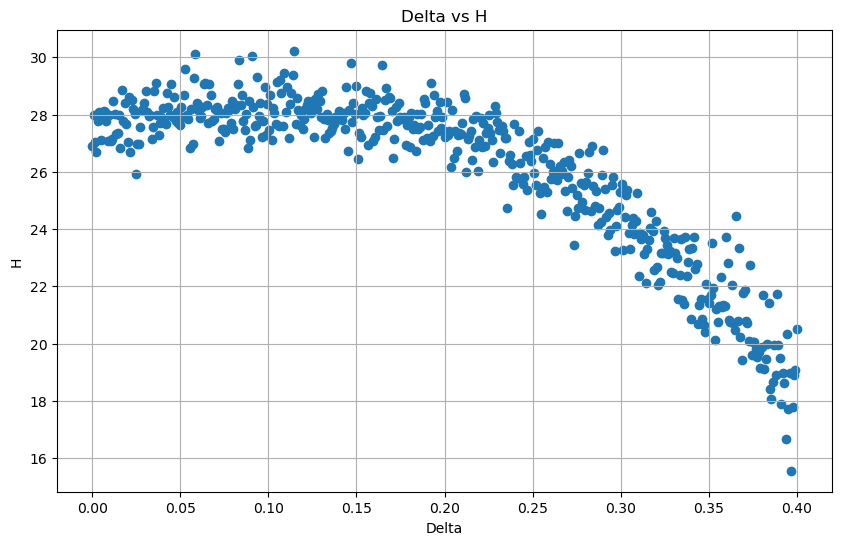

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
rho = 0.90
iota = 0.01
sigma_eps = 0.10
R = (1+0.01)**(1/12)
eta = 0.5 # assuming eta from the earlier problem
w = 1 # assuming a wage rate
K = 51 # number of simulations for approximation
T = 120 # 10 years, 120 months

# Function to generate kappa_t
def generate_kappa(rho, sigma_eps, T, seed):
    np.random.seed(seed)
    eps = np.random.normal(-0.5 * sigma_eps**2, sigma_eps, T)
    kappa = np.empty(T)
    kappa[0] = 1
    for t in range(1, T):
        kappa[t] = np.exp(rho * np.log(kappa[t-1]) + eps[t])
    return kappa

# Function to calculate l_t
def calculate_lt(kappa, w, eta, Delta):
    l = np.empty(T)
    l[0] = 0
    l_star = np.empty(T)
    for t in range(1, T):
        l_star[t] = ((1 - eta) * kappa[t] / w)**(1 / eta)
        if np.abs(l[t-1] - l_star[t]) > Delta:
            l[t] = l_star[t]
        else:
            l[t] = l[t-1]    
    return l

# Function to calculate ex post value
def calculate_h(kappa, l, R, w, eta, iota, T):
    h = 0
    for t in range(T):
        h += R**(-t) * (kappa[t] * l[t]**(1 - eta) - w * l[t] - int(l[t] != l[t - 1]) * iota)
    return h


# Looping over Delta loop 10 times

Deltas = []
H_values = []



# Check a range of Delta values
for Delta in np.linspace(0, 0.4, 500):  # Adjust the range and step size as needed

    # Run simulations for new policy
    H_values_new = []
    for k in range(K):
        kappa = generate_kappa(rho, sigma_eps, T, np.random.seed(k))
        l = calculate_lt(kappa, w, eta, Delta)
        h = calculate_h(kappa, l, R, w, eta, iota, T)
        H_values_new.append(h)

    # Calculate H for new policy
    H_new = np.mean(H_values_new)
    
    Deltas.append(Delta)
    H_values.append(H_new)
    
    if H_new > max_H_new:
        max_H_new = H_new
        best_Delta = Delta
            
    
print(f"The mean best Delta value over 10 runs is {best_Delta:.2f}")


# Plot Delta vs H
plt.figure(figsize=(10, 6))
plt.scatter(Deltas, H_values)
plt.xlabel("Delta")
plt.ylabel("H")
plt.title("Delta vs H")
plt.grid(True)
plt.show()




**Question 5:** Suggest an alternative policy you believe might improve profitability. Implement and test your policy.



In [29]:
import numpy as np
import random

# Parameters
rho = 0.90
iota = 0.01
sigma_eps = 0.10
R = (1+0.01)**(1/12)
eta = 0.5 # assuming eta from the earlier problem
w = 1 # assuming a wage rate
K = 50 # number of simulations for approximation
T = 120 # 10 years, 120 months
Delta = 0.1 # change threshold

# Function to generate kappa_t
def generate_kappa(rho, sigma_eps, T, seed):
    np.random.seed(seed)
    eps = np.random.normal(-0.5 * sigma_eps**2, sigma_eps, T)
    kappa = np.empty(T)
    kappa[0] = 1
    for t in range(1, T):
        kappa[t] = np.exp(rho * np.log(kappa[t-1]) + eps[t])
    return kappa


# Function to calculate l_t
def calculate_lt(kappa, w, eta, Delta):
    l = np.empty(T)
    l[0] = 0
    l_star = np.empty(T)
    for t in range(1, T):
        l_star[t] = ((1 - eta) * kappa[t] / w)**(1 / eta)
        if np.abs(l[t-1] - l_star[t]) > Delta:
            l[t] = l_star[t]
        else:
            l[t] = l[t-1]    
    return l

# Function to calculate ex post value
def calculate_h(kappa, l, R, w, eta, iota, T):
    h = 0
    for t in range(T):
        h += R**(-t) * (kappa[t] * l[t]**(1 - eta) - w * l[t] - int(l[t] != l[t - 1]) * iota)
    return h

# Function to calculate ex post value
def calculate_h_extention(kappa, l, R, w, eta, iota, T):
    h = 0
    for t in range(T):
        h += R**(-t) * (kappa[t] * l[t]**(1 - eta) - w * l[t] - (l[t] - l[t - 1]) * iota)
    return h

improvement = np.empty(50)
for i in range(50):
    # Run simulations for old policy
    H_values_extention = []
    for k in range(K):
        kappa = generate_kappa(rho, sigma_eps, T, (i+1)*(k+1))
        l = ((1 - eta) * kappa / w)**(1 / eta)
        h = calculate_h_extention(kappa, l, R, w, eta, iota, T)
        H_values_extention.append(h)

    # Calculate H for old policy
    H_extention = np.mean(H_values_extention)

    # Run simulations for new policy
    H_values_Delta = []
    for k in range(K):
        kappa = generate_kappa(rho, sigma_eps, T, (i+1)*(k+1))
        l = calculate_lt(kappa, w, eta, Delta)
        h = calculate_h(kappa, l, R, w, eta, iota, T)
        H_values_Delta.append(h)

    # Calculate H for new policy
    H_Delta = np.mean(H_values_Delta)

    #Improvement
    improvement[i] = H_extention - H_Delta

# Print results
print(f'On average, the our new extention improves profitability with {np.mean(improvement):.2f}.')


On average, the our new extention improves profitability with 0.70.


## 3. <a id='toc3_'></a>[Problem 3: Global optimizer with refined multi-start](#toc0_)

We consider the Griewank function:

$$ f(\boldsymbol{x}) = \sum^n_{i=1} \frac{x^2_i}{4000}-\prod^n_{i=1}\cos\left(\frac{x_i}{\sqrt{i}}\right)+1$$

The **global minimum** of this function is $f(0,0) = 0$ (remember: $\cos(0)=1$).<br>
But the function also have a lot of **local minima**.

In [ ]:
def griewank(x):
    return griewank_(x[0],x[1])
    
def griewank_(x1,x2):
    A = x1**2/4000 + x2**2/4000
    B = np.cos(x1/np.sqrt(1))*np.cos(x2/np.sqrt(2))
    return A-B+1

A **refined global optimizer with multi-start** is:

1. Choose *bounds* for $\mathbf{x}$ and *tolerance* $\tau > 0$.
2. Choose number of *warm-up iterations*, $\underline{K} > 0$ and *maximum number of iterations*, $K > \underline{K}$.
3. In each iteration for $k \in \{0,1,\dots,K-1\}$:

    A. Draw random $\mathbf{x}^k$ uniformly within chosen bounds.

    B. If $k < \underline{K}$ go to step E.

    C. Calculate $\chi^k = 0.50\cdot\frac{2}{1+\exp((k-\underline{K})/100)}$  

    D. Set $\mathbf{x}^{k0} = \chi^k \mathbf{x}^k + (1-\chi^k)\mathbf{x}^{\ast} $

    E. Run optimizer with $\mathbf{x}^{k0}$ as initial guess and $\mathbf{x}^{k\ast}$ as result.

    F. Set $\mathbf{x}^{\ast} = \mathbf{x}^{k\ast}$ if $k = 0$ or $f(\mathbf{x}^{k\ast}) < f(\mathbf{x}^{\ast})$

    G. If $f(\mathbf{x}^{\ast}) < \tau$ go to step 4.

4. Return the result $\mathbf{x}^{\ast}$.

As settings we choose:

* $x_1,x_2 \in  [-600,600]$
* $\tau = 10^{-8}$
* $\underline{K}=10$
* $K=1000$

The optimizer in Step 3.E is `BFGS` with a tolerance of $\tau$.

**Question 1:** Implement the refined global optimizer with multi-start. Illustrate how the effective initial guesses $\mathbf{x}^{k0}$ vary with the iteration counter $k$.

In [ ]:
# write your code here

**Question 2:** Is it a better idea to set $\underline{K} = 100$? Is the convergence faster?

In [ ]:
# write your code here